<a href="https://colab.research.google.com/github/Lariiuki/Pos-Deep-Learning/blob/main/NoProp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Teste 'NoProp'

In [18]:
#!pip install torch torchvision matplotlib

In [19]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [20]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("leonardoreboucas/imagens-de-animais-para-classificao")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imagens-de-animais-para-classificao


In [21]:
import os

print(os.listdir(path))

['Dataset']


In [22]:
for root, dirs, files in os.walk(path):
    print("Pasta:", root)
    print("Arquivos:", len(files))

Pasta: /kaggle/input/imagens-de-animais-para-classificao
Arquivos: 0
Pasta: /kaggle/input/imagens-de-animais-para-classificao/Dataset
Arquivos: 0
Pasta: /kaggle/input/imagens-de-animais-para-classificao/Dataset/passaros
Arquivos: 300
Pasta: /kaggle/input/imagens-de-animais-para-classificao/Dataset/gatos
Arquivos: 300
Pasta: /kaggle/input/imagens-de-animais-para-classificao/Dataset/peixes
Arquivos: 300
Pasta: /kaggle/input/imagens-de-animais-para-classificao/Dataset/elefante
Arquivos: 300
Pasta: /kaggle/input/imagens-de-animais-para-classificao/Dataset/borboleta
Arquivos: 300
Pasta: /kaggle/input/imagens-de-animais-para-classificao/Dataset/aranha
Arquivos: 300
Pasta: /kaggle/input/imagens-de-animais-para-classificao/Dataset/cachorros
Arquivos: 300
Pasta: /kaggle/input/imagens-de-animais-para-classificao/Dataset/galinha
Arquivos: 300
Pasta: /kaggle/input/imagens-de-animais-para-classificao/Dataset/carneiro
Arquivos: 300
Pasta: /kaggle/input/imagens-de-animais-para-classificao/Dataset/bov

In [23]:
import torch

if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print("Using device:", device)

Using device: cpu


In [24]:
# Denoising block
import torch.nn as nn
import torch.nn.functional as F

# limpeza do ruído na base
# Pega a imagem (x) e extrai características com convoluções (CNN).
# Pega o embedding ruidoso (z_prev) e passa por fully connected layers.
# Combina x_feat e z_feat e gera uma previsão (logits e z_next).
class DenoiseBlock(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super().__init__()
        # Image path
        self.conv_path = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256)
        )

        # Noisy embedding path
        self.fc_z1 = nn.Linear(embedding_dim, 256)
        self.bn_z1 = nn.BatchNorm1d(256)

        self.fc_z2 = nn.Linear(256, 256)
        self.bn_z2 = nn.BatchNorm1d(256)

        self.fc_z3 = nn.Linear(256, 256)
        self.bn_z3 = nn.BatchNorm1d(256)

        # Combined downstream path
        self.fc_f1 = nn.Linear(256 + 256, 256)
        self.bn_f1 = nn.BatchNorm1d(256)
        self.fc_f2 = nn.Linear(256, 128)
        self.bn_f2 = nn.BatchNorm1d(128)
        self.fc_out = nn.Linear(128, num_classes)

    def forward(self, x, z_prev, W_embed):
        # Image features
        x_feat = self.conv_path(x)

        # Features from noisy embedding
        h1 = F.relu(self.bn_z1(self.fc_z1(z_prev)))
        h2 = F.relu(self.bn_z2(self.fc_z2(h1)))
        h3 = self.bn_z3(self.fc_z3(h2))

        z_feat = h3 + h1 # Residual connection

        # Combine and predict logits
        h_f = torch.cat([x_feat, z_feat], dim=1)
        h_f = F.relu(self.bn_f1(self.fc_f1(h_f)))
        h_f = F.relu(self.bn_f2(self.fc_f2(h_f)))
        logits = self.fc_out(h_f)

        # Softmax on logits
        p = F.softmax(logits, dim=1)
        z_next = p @ W_embed

        return z_next, logits

In [25]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import math

class NoPropDT(nn.Module):
    def __init__(self, num_classes, embedding_dim, T, eta):
        super().__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.T = T
        self.eta = eta

        # Stacking up the Denoise blocks
        self.blocks = nn.ModuleList([
            DenoiseBlock(embedding_dim, num_classes) for _ in range(T)
        ])

        # Class-embedding matrix (W_embed)
        self.W_embed = nn.Parameter(torch.randn(num_classes, embedding_dim) * 0.1)

        # Classification head
        self.classifier = nn.Linear(embedding_dim, num_classes)

        # Cosine noise schedule
        t = torch.arange(1, T+1, dtype=torch.float32)
        alpha_t = torch.cos(t / T * (math.pi/2))**2
        alpha_bar = torch.cumprod(alpha_t, dim=0)
        snr = alpha_bar / (1 - alpha_bar)
        snr_prev = torch.cat([torch.tensor([0.], dtype=snr.dtype), snr[:-1]], dim=0)
        snr_diff = snr - snr_prev

        self.register_buffer('alpha_bar', alpha_bar)
        self.register_buffer('snr_diff', snr_diff)

    def forward_denoise(self, x, z_prev, t):
        return self.blocks[t](x, z_prev, self.W_embed)[0]

    def classify(self, z):
        return self.classifier(z)

    def inference(self, x):
        B = x.size(0)
        z = torch.randn(B, self.embedding_dim, device=x.device)

        for t in range(self.T):
            z = self.forward_denoise(x, z, t)

        return self.classify(z)

In [26]:
# Function for training NoProp-DT

def train_nopropdt(model, train_loader, test_loader, epochs, lr, weight_decay):
    # Using AdamW optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
    )

    # Dict to store metrics
    history = {'train_acc': [], 'val_acc': []}

    for epoch in range(1, epochs + 1):
        model.train()

        for t in range(model.T):
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                uy = model.W_embed[y]
                alpha_bar_t = model.alpha_bar[t]
                noise = torch.randn_like(uy)
                z_t = torch.sqrt(alpha_bar_t) * uy + torch.sqrt(1 - alpha_bar_t) * noise

                z_pred, _ = model.blocks[t](x, z_t, model.W_embed)
                loss_l2 = F.mse_loss(z_pred, uy)
                loss = 0.5 * model.eta * model.snr_diff[t] * loss_l2

                if t == model.T - 1:
                    logits = model.classifier(z_pred)
                    loss_ce = F.cross_entropy(logits, y)
                    loss_kl = 0.5 * uy.pow(2).sum(dim=1).mean()
                    loss = loss + loss_ce + loss_kl

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

        # Training accuracy
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                preds = model.inference(x).argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        train_acc = correct / total

        # Validation accuracy
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                preds = model.inference(x).argmax(dim=1)
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)

        val_acc = val_correct / val_total
        scheduler.step(val_acc) # Moved after val_acc calculation

        # Storing accuracy history
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch}/{epochs}  "
              f"TrainAcc={100 * train_acc:.2f}%  ValAcc={100 * val_acc:.2f}%")

    # Plotting Training and Validation accuracy
    plt.figure()
    plt.plot(range(1, epochs + 1), history['train_acc'], label='Train Accuracy')
    plt.plot(range(1, epochs + 1), history['val_acc'], label='Validation Accuracy')
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\n Final Test Accuracy: {100 * val_acc:.2f}%")

In [27]:
# Hyperparameters

T = 3                # menos blocos de denoising
eta = 0.05           # suaviza a loss
embedding_dim = 128  # embedding menor
batch_size = 16      # lotes pequenos (dataset pequeno)
lr = 1e-4            # taxa de aprendizado menor (para não explodir)
epochs = 40          # mais épocas, porque são poucas imagens
weight_decay = 1e-4  # regularização mais leve

In [28]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformações (redimensionar e converter em tensor)
transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# Carregar dataset (aponta para a pasta Dataset)
train_set = datasets.ImageFolder(
    root="/root/.cache/kagglehub/datasets/leonardoreboucas/imagens-de-animais-para-classificao/versions/1/Dataset",
    transform=transform
)

# DataLoader (permite treinar em lotes)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
print("Classes:", train_set.classes)
print("Número total de imagens no dataset:", len(train_set))
print("Classes encontradas:", train_set.classes)
print("Número de imagens por classe:")
for i, cls in enumerate(train_set.classes):
    count = sum([1 for label in train_set.targets if label == i])
    print(f"{cls}: {count}")

Classes: ['aranha', 'borboleta', 'bovino', 'cachorros', 'carneiro', 'cavalo', 'elefante', 'esquilo', 'galinha', 'gatos', 'passaros', 'peixes']
Número total de imagens no dataset: 3600
Classes encontradas: ['aranha', 'borboleta', 'bovino', 'cachorros', 'carneiro', 'cavalo', 'elefante', 'esquilo', 'galinha', 'gatos', 'passaros', 'peixes']
Número de imagens por classe:
aranha: 300
borboleta: 300
bovino: 300
cachorros: 300
carneiro: 300
cavalo: 300
elefante: 300
esquilo: 300
galinha: 300
gatos: 300
passaros: 300
peixes: 300


In [29]:
num_classes = len(train_set.classes)
num_classes

12

In [30]:
from torch.utils.data import random_split

# Tamanho do dataset
dataset_size = len(train_set)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# Divisão
train_subset, test_subset = random_split(train_set, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_subset,  batch_size=batch_size, shuffle=False)

In [31]:
model = NoPropDT(num_classes=num_classes,
                 embedding_dim=512,
                 T=10,
                 eta=0.1).to(device)

Epoch 1/40  TrainAcc=11.25%  ValAcc=10.83%
Epoch 2/40  TrainAcc=10.66%  ValAcc=9.86%
Epoch 3/40  TrainAcc=9.38%  ValAcc=9.72%
Epoch 4/40  TrainAcc=12.33%  ValAcc=12.64%
Epoch 5/40  TrainAcc=10.03%  ValAcc=11.67%
Epoch 6/40  TrainAcc=14.65%  ValAcc=16.11%
Epoch 7/40  TrainAcc=16.39%  ValAcc=16.67%
Epoch 8/40  TrainAcc=14.97%  ValAcc=15.14%
Epoch 9/40  TrainAcc=17.88%  ValAcc=17.64%
Epoch 10/40  TrainAcc=14.93%  ValAcc=16.11%
Epoch 11/40  TrainAcc=15.83%  ValAcc=16.67%
Epoch 12/40  TrainAcc=18.16%  ValAcc=18.19%
Epoch 13/40  TrainAcc=21.04%  ValAcc=21.39%
Epoch 14/40  TrainAcc=21.01%  ValAcc=19.86%
Epoch 15/40  TrainAcc=20.69%  ValAcc=20.00%
Epoch 16/40  TrainAcc=22.08%  ValAcc=22.92%
Epoch 17/40  TrainAcc=19.93%  ValAcc=19.72%
Epoch 18/40  TrainAcc=23.61%  ValAcc=24.44%
Epoch 19/40  TrainAcc=23.89%  ValAcc=25.14%
Epoch 20/40  TrainAcc=22.57%  ValAcc=22.36%
Epoch 21/40  TrainAcc=24.31%  ValAcc=23.33%
Epoch 22/40  TrainAcc=24.13%  ValAcc=22.64%
Epoch 23/40  TrainAcc=24.41%  ValAcc=24.17%


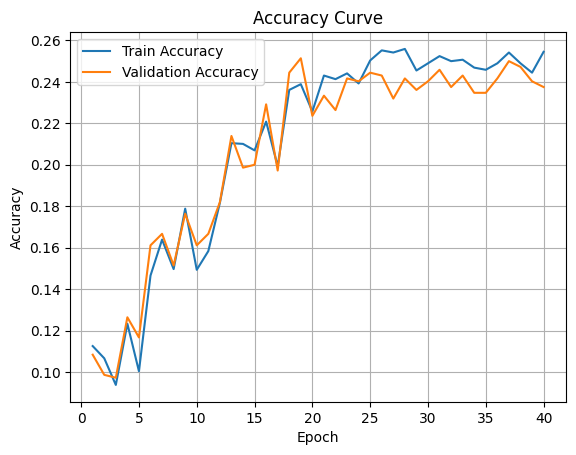


 Final Test Accuracy: 23.75%


In [32]:
train_nopropdt(model, train_loader, test_loader, epochs=epochs, lr=lr, weight_decay=weight_decay)

In [37]:
def show_predictions(model, test_loader, class_names=None, num_images = 16):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(5, 5))

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model.inference(x)
            preds = logits.argmax(dim=1)

            for i in range(x.size(0)):
                if images_shown >= num_images:
                    break

                plt.subplot(int(num_images**0.5), int(num_images**0.5), images_shown + 1)
                img = x[i].cpu().permute(1, 2, 0)
                plt.imshow(img, cmap='gray')
                actual = class_names[y[i]] if class_names else y[i].item()
                pred = class_names[preds[i]] if class_names else preds[i].item()
                plt.title(f"Pred: {pred}\nTrue: {actual}", fontsize=8)
                plt.axis('off')

                images_shown += 1

            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()

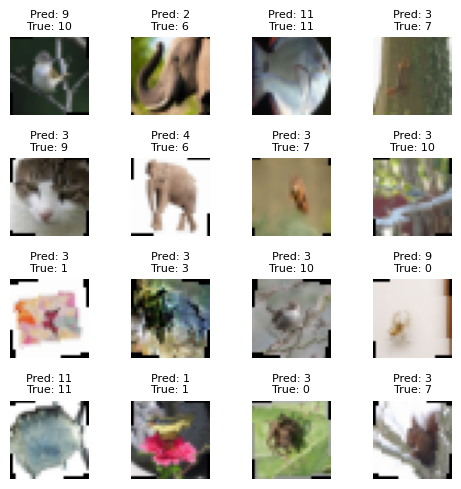

In [38]:
# Class names for MNIST dataset
class_names = [str(i) for i in range(10)]

# Call the function
show_predictions(model, test_loader)